# Analysis of models 

The following notebook will analyze the performance of our models as well as break down the feature importance of each model. After analyzing our results, we will discuss the results & find out if the project was succesful or not.

## Dataset
The dataset we found via this [kaggle](https://www.kaggle.com/hemanthhari/symptoms-and-covid-presence) link contains information on patients who took the COVID-19 test. There is a total of 5434 rows & 21 columns. Each row corresponds to a patient's symptoms, where each column represent a symptom. In order to correctly pre-process the data, we removed features such as "contacted someone with the virus" or "recently travelled". The reason why is because we want to focus on tangible symptoms & see which symptoms indicate early stages of COVID-19. 

From the 5434 patients, 81% (4383) were later tested positive for the virus. Therefore, we needed to do something about the data imbalance.

## Imbalance
bad ecris ici a propos de ton outil, met le link et explique ce quon a fais

### Imports

In [2]:
import models.utils as utils
import models.naive_bayes as gnb
import models.decision_tree as dt
import models.random_forest as rf
import models.support_vector_machine as svm
import models.neural_network as nn
import models.utils as utils
import models.preprocess as preprocess
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## 1. Gaussian Naive Bayes
In this section, we analyze the performance & feature importances of the GNB classifier. Initially, we will write a function we will use everything to display bar charts presenting the symptoms & their weight importance.

### 1.1 Feature Importance

In [3]:
def plt_bar_chart(features, weight, classifier, feat_type, yes, no):
    plt.barh(features, weight)
    plt.ylabel('Symptoms')
    plt.xlabel('Importance Weight')
    plt.title(f'{classifier} {feat_type} with size (Yes: {yes}, No: {no})')

Running Gaussian Naive Bayes...
Original dataset shape Counter({1: 4383, 0: 1051})


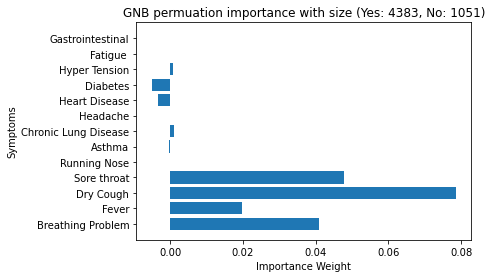

In [3]:
features = utils.get_feature_names()
feature_importances = sorted(gnb.naive_bayes(isNotebook = True))
_, weight = zip(*feature_importances)
plt_bar_chart(features, weight, "GNB", "permuation importance", 4383, 1051)

As we can see, the top three symptoms for the Naive Bayes model are:
- Dry cough
- Sore Throat
- Breathing Problems

Fever came close 3rd but we can see its weight is significantly higher than other symptoms. But, what do these numbers represent? 

##### Permutation Importance
If we look at GNB's in general, they do not naively have a ```feature_importances_``` output parameter like other models. Therefore, we used the notion of **permutation importance**. Permutation importance works by shuffling features. If shuffling a symptom made the model perform worse, then it suggests that this symptom is important. Therefore, it is assigned a postiive value.

#### Scaling up
Let's scale up the data to 1:2 & see the results

Running Gaussian Naive Bayes...
Original dataset shape Counter({1: 4383, 0: 1051})
Oversampled dataset shape Counter({1: 4383, 0: 2191})


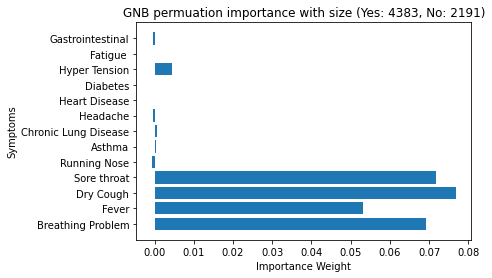

In [4]:
features = utils.get_feature_names()
feature_importances = sorted(gnb.naive_bayes(sampling = True, isNotebook = True))
_, weight = zip(*feature_importances)
plt_bar_chart(features, weight, "GNB", "permuation importance", 4383, 2191)

As we can see, the top three symptoms for the scaled up Naive Bayes model are:
- Breathing Problems
- Sore Throat
- Dry Cough

The order changed, but, the order does not matter in this case. As we can see, all features are scaled up but the symptoms remain the same.

### 1.2 Model performance
While the purpose of the project is to analyse feature importances, we thought it would be interesting to share how our models performed.

#### Confusion Matrix

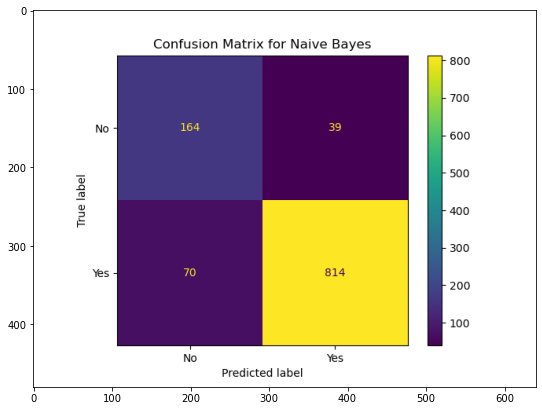

In [5]:
image = mpimg.imread("../results/GNB/confusion_matrix.png")
plt.figure(figsize = (9,9))
plt.imshow(image);

As we can see, there are 70 FN & 39 FP. Considering that GNB is a basic model, it's not bad as a baseline. Obviously, we seek to have a stronger model, we hope to achieve that with the fancier models ahead. In terms of metrics, the F1 score of negative cases came to 0.751 while the F1 score of positive cases is 0.937. 

Please note that **all metrics** observed are saved inside the ```results``` folder.

### 1.3 Conclusion
We did not expect the GNB to perform superbly & this was expected. The importance is that we got our three most important features which are **breathing problems, sore throat & dry cough**. 

## 2. Decision Tree
In this section, we analyze the performance & feature importances of the Decision Tree classifier.

### 2.1 Feature Importance


Running Decision Tree...
Original dataset shape Counter({1: 4383, 0: 1051})
====================Best parameters found====================
{'splitter': 'best', 'min_samples_split': 4, 'min_samples_leaf': 2, 'criterion': 'gini'}


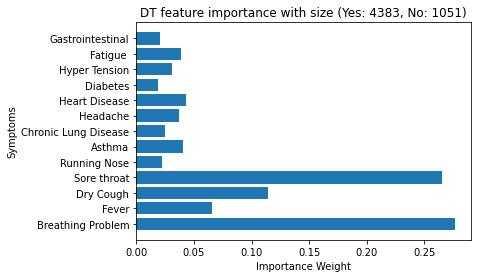

In [7]:
feature_tuples, best_model = dt.decision_tree(isNotebook = True)
features = utils.get_feature_names()
feature_importances = sorted(feature_tuples)
_, weight = zip(*feature_importances)
plt_bar_chart(features, weight, "DT", "feature importance", 4383, 1051)

print(f'{20*"="}Best parameters found{20*"="}')
print(best_model.best_params_)

As we can see, the top three symptoms for the Decision Tree model are:
- Breathing Problems
- Sore Throat
- Dry Cough

Fever came close 3rd again, but, unlike GNB, the other symptoms have more weight. In this case, we used Decision Tree's ```feature_importances_```. Let's take a look at our hyperparameters.

###### Hyperparameters
```
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'min_samples_split': [2, 4, 5, 10, 13],
    'min_samples_leaf': [1, 2, 5, 8, 13]
}
```
From the parameter grid, we used the validation set in order to find the best combination. In the end, it came out to be the following:

```
'splitter': 'best'
'min_samples_split': 4
'min_samples_leaf': 2
'criterion': 'gini'
```

#### Scaling up
Let's scale up the data to 1:2 & see the results


Running Decision Tree...
Original dataset shape Counter({1: 4383, 0: 1051})
Oversampled dataset shape Counter({1: 4383, 0: 2191})


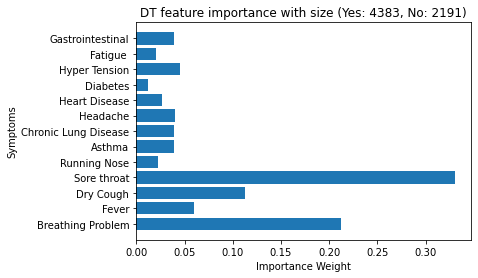

In [8]:
feature_tuples, best_model = dt.decision_tree(sampling = True, isNotebook = True)
features = utils.get_feature_names()
feature_importances = sorted(feature_tuples)
_, weight = zip(*feature_importances)
plt_bar_chart(features, weight, "DT", "feature importance", 4383, 2191)

As we can see, the top three symptoms for the scaled up Decision Tree model are:
- Breathing Problems
- Sore Throat
- Dry Cough

There is although an interesting shift in weight for the breathing problem & sore throat. After upscalling the data, we observe the sore throat importance increase while the breathing problems decrease. This suggests that having a sore throat is much more significant than having breathing problems. Let's verify this by upscaling to 3:4 rate.


Running Decision Tree...
Original dataset shape Counter({1: 4383, 0: 1051})
Oversampled dataset shape Counter({1: 4383, 0: 3287})


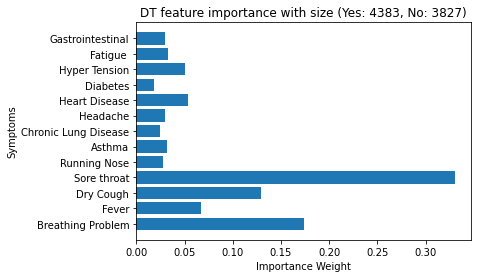

In [7]:
feature_tuples, best_model = dt.decision_tree(sampling = True, isNotebook = True, sampling_rate = 0.75)
features = utils.get_feature_names()
feature_importances = sorted(feature_tuples)
_, weight = zip(*feature_importances)
plt_bar_chart(features, weight, "DT", "feature importance", 4383, 3827)

Indeed, as we see, breathing problems' weight decreases while sore throat suggests that it is a critical feature upon making a prediction.

### 2.2 Model performance
We will look at how performing the decision tree turned out to be with hyperparameter tuning.

#### Confusion Matrix

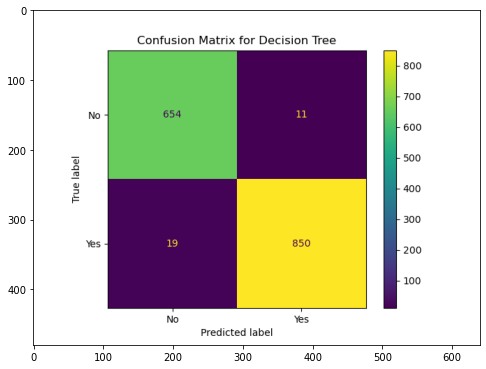

In [14]:
image = mpimg.imread("../results/DecisionTree/confusion_matrix.png")
plt.figure(figsize = (8,8))
plt.imshow(image);

As we can see, the Decision Tree performs much better than the GNB. Previously, there were 70 FN & 39 FP, now, we are at 19 FN & 11 FP. In terms of metrics, the F1 score of negative cases came to 0.978 while the F1 score of positive cases is 0.983. Considering the little amount of data we have, these are impressive figures!

### 2.3 Conclusion
The Decision Tree's most important features are **breathing problems, sore throat & dry cough**. So far, the symptoms agree with each other in each models we have visisted. Also, the decision tree's performance was excellent. 

## 3. Decision Tree
In this section, we analyze the performance & feature importances of the Random Forest classifier.

### 3.1 Feature Importance